# Capstone Three : Sentiment Analysis for Mental Health

This comprehensive dataset is a meticulously curated collection of mental health statuses tagged from various statements. The dataset amalgamates raw data from multiple sources, cleaned and compiled to create a robust resource for developing chatbots and performing sentiment analysis. The dataset contains more than 50,000 statements and their respective status labeled as either “Normal”, “Depression”, “Suicidal”, “Anxiety”, “Bipolar”, “Stress”, and “Personality disorder”.

The dataset is built by Suchintika Sarkar by integrating information from the following Kaggle datasets:

1. 3k Conversations Dataset for Chatbot
2. Depression Reddit Cleaned
3. Human Stress Prediction
4. Predicting Anxiety in Mental Health Data
5. Mental Health Dataset Bipolar
6. Reddit Mental Health Data
7. Students Anxiety and Depression Dataset
8. Suicidal Mental Health Dataset
9. Suicidal Tweet Detection Dataset

The dataset contains following features:

1. unique_id: A unique identifier for each entry.
2. Statement: The textual data or post.
3. Mental Health Status: The tagged mental health status of the statement.
   
The data is available for download on https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health. I plan to develop my own Sentiment analysis to gauge mental health trends from this data. This project falls under the Natural Language Processing (NLP) project.


 ## Data Wrangling

### 1. Importing Required Modules and Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import spacy
import random
%matplotlib inline

### 2. Loading and Scanning Data

In [2]:
sentiment_df = pd.read_csv("../data/Raw_data/Combined Data.csv").drop(["Unnamed: 0"], axis=1)

sentiment_df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


The data contains two columns filled with object type data.

In [4]:
sentiment_df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


**There seems to be some missing data in statement column as count in two columns are not matching.**

Before checking the missing data lets first look at the label of each status and number of statements corresponding to each of them

In [5]:
status_count = sentiment_df.status.value_counts()
status_count

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

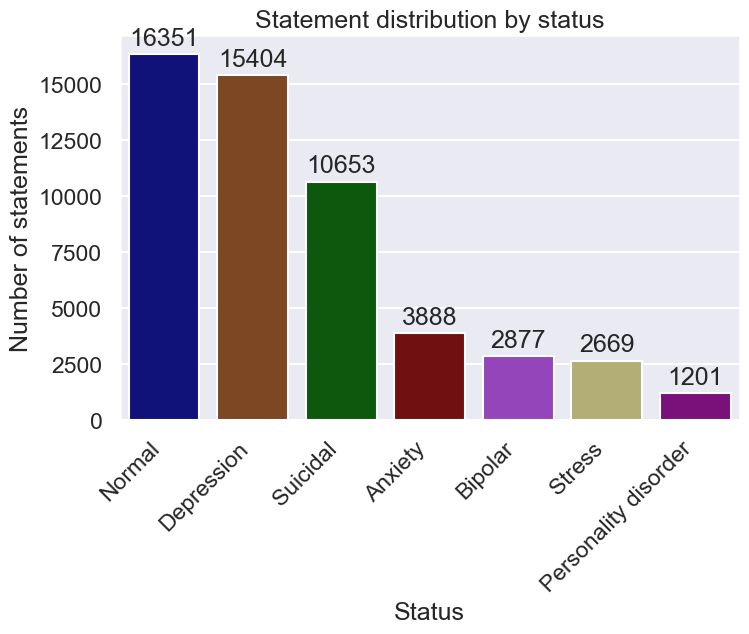

In [6]:
sns.set_theme("talk")

plt.figure(figsize=(8, 5))
palette = {
    "Normal": "#00008B",
    "Depression": "#8B4513",
    "Suicidal": "#006400",
    "Anxiety": "#800000",
    "Bipolar": "#9932CC",
    "Stress": "#BDB76B",
    "Personality disorder": "#8B008B"
}
# Create barplot
ax = sns.barplot(x=status_count.index, y=status_count.values,hue =status_count.index,  palette=palette)

# Add values at the top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f', label_type='edge', padding=3)

plt.title('Statement distribution by status')
plt.xlabel('Status')
plt.ylabel('Number of statements')
plt.xticks(rotation=45, ha="right")

plt.show()

The target variable of the dataset is not balanced. The lack of balance could infact lower the performance of the predictive model and hence should be taken care before building a model.

Now let us check the category distribution among missing values.

### 3. Handling the missing values

In [7]:
sentiment_df.isna().sum()

statement    362
status         0
dtype: int64

In [8]:
missing_counts = sentiment_df[sentiment_df.isnull().any(axis=1)]["status"].value_counts()
missing_counts

status
Personality disorder    124
Bipolar                 100
Stress                   82
Anxiety                  47
Normal                    8
Suicidal                  1
Name: count, dtype: int64

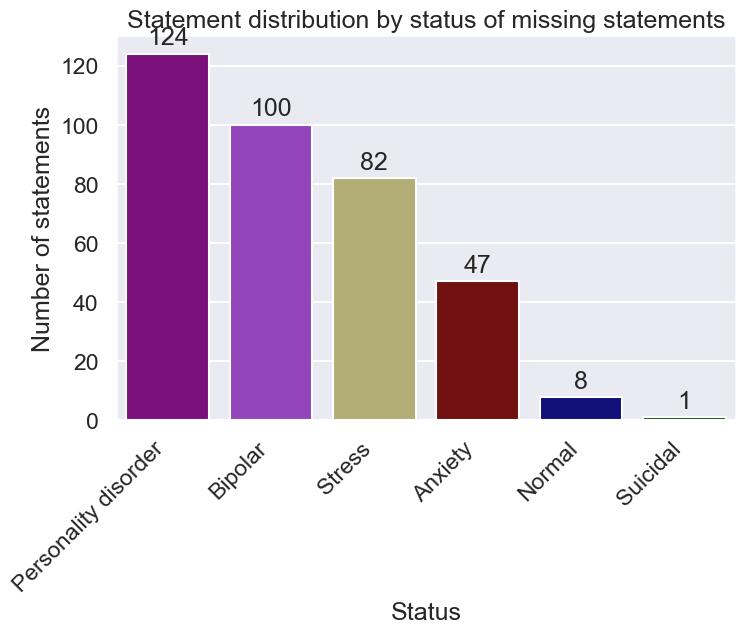

In [9]:


plt.figure(figsize=(8, 5))

# Create barplot
ax = sns.barplot(x=missing_counts.index, y=missing_counts.values,hue =missing_counts.index,  palette=palette)

# Add values at the top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f', label_type='edge', padding=3)

plt.title('Statement distribution by status of missing statements')
plt.xlabel('Status')
plt.ylabel('Number of statements')
plt.xticks(rotation=45, ha="right")

plt.show()

The category distribution in missing statement case is drastically different from the distribution whole dataset. This implies that the missing data itself can carry some information regarding the status. Hence instead of dropping those data, here I have decided to impute them with "unfilled" as statement.

In [10]:
sentiment_df = sentiment_df.fillna("unfilled")

### 4. Preprocessing the text

In [11]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [12]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL) 
                                                                    # This pattern matches any contraction found in the 
                                                                    # contraction_mapping dictionary
    def expand_match(contraction): 
        #  helper function that is applied whenever a contraction is found in the text
        match = contraction.group(0) # captures the full contraction that was found
        first_char = match[0] # stores the first character of the contraction, to handle the case 
                                # where the contraction starts with an uppercase letter
        expanded_contraction = contraction_mapping.get(match) if contraction_mapping.get(match) else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text) #Here, sub() searches the text for matches based on the regular expression
                                                                #(contractions_pattern). Whenever a contraction is found, expand_match is 
                                                                # called, and the match object representing the contraction is passed as 
                                                                # an argument to expand_match.
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [13]:
def cleaned_text(text):
    # Convert to string and lowercase
    text = str(text).lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>+', '', text)
    
    # Remove accented characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Remove URLs (including markdown-style links)
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]\(.*?\)', '', text)
    
    
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)

    # Remove punctuation and other special characters
    text = re.sub(f'[{re.escape(string.punctuation.replace("_", ""))}]', ' ', text)
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Reduce sequences of the same character that appear three or more times
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Expanding Contractions
    text = expand_contractions(text)
     
    # Remove newline characters
    text = re.sub(r'[\r|\n|\r\n]+', ' ', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    return text.strip()


In [14]:
sentiment_df_cleaned = sentiment_df.copy()
sentiment_df_cleaned["statement_cleaned"] = sentiment_df_cleaned["statement"].apply(cleaned_text)
sentiment_df_cleaned.head()

,statement,status,statement_cleaned
0,oh my gosh,Anxiety,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,i ve shifted my focus to something else but i ...
4,"I'm restless and restless, it's been a month n...",Anxiety,i m restless and restless it s been a month no...


### 5. Removing Stopwords

In [15]:
# Set of English stop words
stop_words = set(nltk.corpus.stopwords.words('english'))

# Function to remove stop words from text
def remove_stopwords(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words and join the remaining tokens back into a string
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Apply the function to the 'statement_cleaned' column
sentiment_df_cleaned['statement_cleaned'] = sentiment_df_cleaned['statement_cleaned'].apply(remove_stopwords)

sentiment_df_cleaned.head()

,statement,status,statement_cleaned
0,oh my gosh,Anxiety,oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,Anxiety,shifted focus something else still worried
4,"I'm restless and restless, it's been a month n...",Anxiety,restless restless month boy mean


### 6. Tokenization 

In [16]:
sentiment_df_cleaned['tokens'] = sentiment_df_cleaned['statement_cleaned'].apply(word_tokenize)
sentiment_df_cleaned.head()

,statement,status,statement_cleaned,tokens
0,oh my gosh,Anxiety,oh gosh,"[oh, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,wrong back dear forward doubt stay restless re...,"[wrong, back, dear, forward, doubt, stay, rest..."
3,I've shifted my focus to something else but I'...,Anxiety,shifted focus something else still worried,"[shifted, focus, something, else, still, worried]"
4,"I'm restless and restless, it's been a month n...",Anxiety,restless restless month boy mean,"[restless, restless, month, boy, mean]"


### 7. Stemming

Stemming is the process of reducing words to their base or root form, typically by removing prefixes or suffixes. It’s a common technique in natural language processing (NLP) to help standardize words so that variations of a word (like "running," "ran," and "runner") are treated as the same base form ("run").

**Popular Stemming Algorithms**

**Porter Stemmer**: A widely used, rule-based algorithm that removes common suffixes. It’s simple and fast but can be aggressive, sometimes producing stems that aren’t real words (e.g., "univers" for "universe").

**Snowball Stemmer**: An extension of Porter with more rules, designed to handle different languages and offer better accuracy.

**Lancaster Stemmer**: A more aggressive algorithm that often reduces words to very short stems, which may not always be intuitive.

In [17]:
stemmer = nltk.SnowballStemmer("english")

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
sentiment_df_cleaned['tokens_joined'] = sentiment_df_cleaned['tokens'].apply(stem_tokens)
sentiment_df_cleaned.head()


,statement,status,statement_cleaned,tokens,tokens_joined
0,oh my gosh,Anxiety,oh gosh,"[oh, gosh]",oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart tune
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,wrong back dear forward doubt stay restless re...,"[wrong, back, dear, forward, doubt, stay, rest...",wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,Anxiety,shifted focus something else still worried,"[shifted, focus, something, else, still, worried]",shift focus someth els still worri
4,"I'm restless and restless, it's been a month n...",Anxiety,restless restless month boy mean,"[restless, restless, month, boy, mean]",restless restless month boy mean


In [18]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens and convert them to strings
def lemmatize_tokens(tokens):
    return ' '.join(lemmatizer.lemmatize(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
sentiment_df_cleaned['tokens_joined_lemma'] = sentiment_df_cleaned['tokens'].apply(lemmatize_tokens)
sentiment_df_cleaned.head()

,statement,status,statement_cleaned,tokens,tokens_joined,tokens_joined_lemma
0,oh my gosh,Anxiety,oh gosh,"[oh, gosh]",oh gosh,oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart tune,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,wrong back dear forward doubt stay restless re...,"[wrong, back, dear, forward, doubt, stay, rest...",wrong back dear forward doubt stay restless re...,wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,Anxiety,shifted focus something else still worried,"[shifted, focus, something, else, still, worried]",shift focus someth els still worri,shifted focus something else still worried
4,"I'm restless and restless, it's been a month n...",Anxiety,restless restless month boy mean,"[restless, restless, month, boy, mean]",restless restless month boy mean,restless restless month boy mean


### 8. Feature Engineering

In [19]:
sentiment_df_cleaned["character_count"] = sentiment_df_cleaned['statement'].str.len().values
sentiment_df_cleaned["word_count"] = sentiment_df_cleaned['statement'].str.split().str.len()
sentiment_df_cleaned['sentence_count'] = sentiment_df_cleaned['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))
sentiment_df_cleaned["avg_character_per_word"] = sentiment_df_cleaned["character_count"] / sentiment_df_cleaned["word_count"]
sentiment_df_cleaned["avg_character_per_sentence"] = sentiment_df_cleaned["character_count"] / sentiment_df_cleaned["sentence_count"]
sentiment_df_cleaned["avg_word_per_sentence"] = sentiment_df_cleaned["word_count"] / sentiment_df_cleaned["sentence_count"]
sentiment_df_cleaned = sentiment_df_cleaned[(sentiment_df_cleaned["character_count"]>1)]
sentiment_df_cleaned = sentiment_df_cleaned.sort_values(["character_count"], ascending=False).reset_index(drop = True)
sentiment_df_cleaned.head()

,statement,status,statement_cleaned,tokens,tokens_joined,tokens_joined_lemma,character_count,word_count,sentence_count,avg_character_per_word,avg_character_per_sentence,avg_word_per_sentence
0,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,take anymore take anymore take anymore take an...,"[take, anymore, take, anymore, take, anymore, ...",take anymor take anymor take anymor take anymo...,take anymore take anymore take anymore take an...,32759,6300,1260,5.199841,25.999206,5.000000
1,Please help me understand what I went through ...,Personality disorder,please help understand went going lengthy ahea...,"[please, help, understand, went, going, length...",pleas help understand went go lengthi ahead ti...,please help understand went going lengthy ahea...,27588,5419,374,5.090976,73.764706,14.489305
2,I have only 1 person I can somewhat open to bu...,Suicidal,person somewhat open done certain extent try r...,"[person, somewhat, open, done, certain, extent...",person somewhat open done certain extent tri r...,person somewhat open done certain extent try r...,27390,5248,237,5.219131,115.569620,22.143460
3,DEPRESSION HAS A PURPOSE: HOW TO USE IT RIGHT ...,Bipolar,depression purpose use right text discusses pe...,"[depression, purpose, use, right, text, discus...",depress purpos use right text discuss person e...,depression purpose use right text discus perso...,26163,4804,430,5.446087,60.844186,11.172093
4,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,aa please want stop,"[aa, please, want, stop]",aa pleas want stop,aa please want stop,25302,8,1,3162.750000,25302.000000,8.000000


In [20]:
sentiment_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   statement                   53043 non-null  object 
 1   status                      53043 non-null  object 
 2   statement_cleaned           53043 non-null  object 
 3   tokens                      53043 non-null  object 
 4   tokens_joined               53043 non-null  object 
 5   tokens_joined_lemma         53043 non-null  object 
 6   character_count             53043 non-null  int64  
 7   word_count                  53043 non-null  int64  
 8   sentence_count              53043 non-null  int64  
 9   avg_character_per_word      53043 non-null  float64
 10  avg_character_per_sentence  53043 non-null  float64
 11  avg_word_per_sentence       53043 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 4.9+ MB


**The dataset has numerous lengthy statements, many of which convey suicidal thoughts or indicate signs of depression.**

## Exploratory Data Analysis (EDA)

In [21]:
sentiment_df_cleaned.sort_values(["avg_character_per_word"], ascending=False).head(10)

,statement,status,statement_cleaned,tokens,tokens_joined,tokens_joined_lemma,character_count,word_count,sentence_count,avg_character_per_word,avg_character_per_sentence,avg_word_per_sentence
4,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,aa please want stop,"[aa, please, want, stop]",aa pleas want stop,aa please want stop,25302,8,1,3162.750000,25302.0,8.0
16861,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,Depression,aahh aahh,"[aahh, aahh]",aahh aahh,aahh aahh,584,2,1,292.000000,584.0,2.0
31414,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAG...,Suicidal,aagaffufkccxkxnmdfuvkcidjdjjxnxkzkzknzkzkzlkzz...,[aagaffufkccxkxnmdfuvkcidjdjjxnxkzkzknzkzkzlkz...,aagaffufkccxkxnmdfuvkcidjdjjxnxkzkzknzkzkzlkzz...,aagaffufkccxkxnmdfuvkcidjdjjxnxkzkzknzkzkzlkzz...,197,2,1,98.500000,197.0,2.0
29869,#ì—ì‚¼ë£¸ì‹¸ë¡±010x5934x4115í•˜ë‹ˆì‹¤ìž¥.#ì—ì‚...,Normal,eiiz eyi eiiz ee eiiz e iiz ee ei eiiz sexy qw...,"[eiiz, eyi, eiiz, ee, eiiz, e, iiz, ee, ei, ei...",eiiz eyi eiiz ee eiiz e iiz ee ei eiiz sexi qw...,eiiz eyi eiiz ee eiiz e iiz ee ei eiiz sexy qw...,233,4,1,58.250000,233.0,4.0
26619,Room Cleaning....................................,Normal,room cleaning,"[room, cleaning]",room clean,room cleaning,310,6,1,51.666667,310.0,6.0
27204,TL Cleaning......................................,Normal,tl cleaning,"[tl, cleaning]",tl clean,tl cleaning,297,6,1,49.500000,297.0,6.0
43819,fuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuck,Depression,fuuck,[fuuck],fuuck,fuuck,49,1,1,49.000000,49.0,1.0
27463,TL Cleaning......................................,Normal,tl cleaning,"[tl, cleaning]",tl clean,tl cleaning,290,6,1,48.333333,290.0,6.0
24493,Chronic stress and hypertension in 10 minutes ...,Stress,chronic stress hypertension minutes,"[chronic, stress, hypertension, minutes]",chronic stress hypertens minut,chronic stress hypertension minute,362,8,1,45.250000,362.0,8.0
32374,Glucocorticoid Cascade Hypothesis [https://psy...,Stress,glucocorticoid cascade hypothesis,"[glucocorticoid, cascade, hypothesis]",glucocorticoid cascad hypothesi,glucocorticoid cascade hypothesis,174,4,1,43.500000,174.0,4.0


Clearly, the longest words are not actually the words but random gibberish input either intensionally or by technical mistake. They might reflect the persons mental status though. Calculating features like character counts before addressing any gibberish or irregular entries can capture the current state of the data, which might indeed hold information about data quality or user behavior. For this reason I decided to calculate the new features such as character counts by using the original statements.

In [22]:
sentiment_df_cleaned.describe()

,character_count,word_count,sentence_count,avg_character_per_word,avg_character_per_sentence,avg_word_per_sentence
count,53043.000000,53043.000000,53043.000000,53043.000000,53043.000000,53043.000000
mean,574.818939,112.393285,6.244179,5.289299,129.743383,25.789568
std,844.684200,163.436684,10.660720,13.821070,318.502715,61.963315
min,2.000000,1.000000,1.000000,2.000000,2.000000,0.500000
25%,77.000000,15.000000,1.000000,4.800000,46.894444,9.000000
50%,313.000000,61.000000,3.000000,5.072000,74.000000,14.333333
75%,748.000000,147.500000,8.000000,5.410832,109.195238,21.000000
max,32759.000000,6300.000000,1260.000000,3162.750000,25302.000000,4239.000000


### 1. Distribution of number of characters in each statement

In [23]:
longer_than_3000_character = sentiment_df_cleaned[sentiment_df_cleaned["character_count"]>3000].shape[0]
print(f'Percentage of long statements with more than 3000 characters is {100*longer_than_3000_character/sentiment_df_cleaned.shape[0]} %')

Percentage of long statements with more than 3000 characters is 1.8909186886111269 %


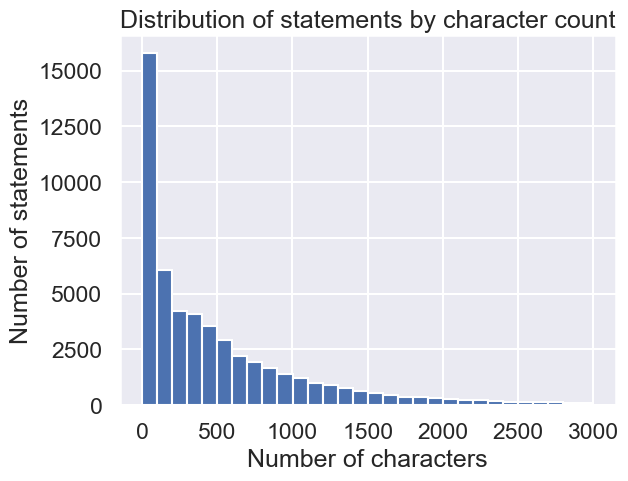

In [38]:
plt.hist(sentiment_df_cleaned[sentiment_df_cleaned["character_count"]<3000]["character_count"], bins = 30)
plt.title('Distribution of statements by character count')
plt.xlabel('Number of characters')
plt.ylabel('Number of statements')

plt.show()

In [25]:
longer_than_500_words = sentiment_df_cleaned[sentiment_df_cleaned["word_count"]>500].shape[0]
print(f'Percentage of long statements with more than 500 words is {100*longer_than_500_words/sentiment_df_cleaned.shape[0]} %')

Percentage of long statements with more than 500 words is 2.8071564579680635 %


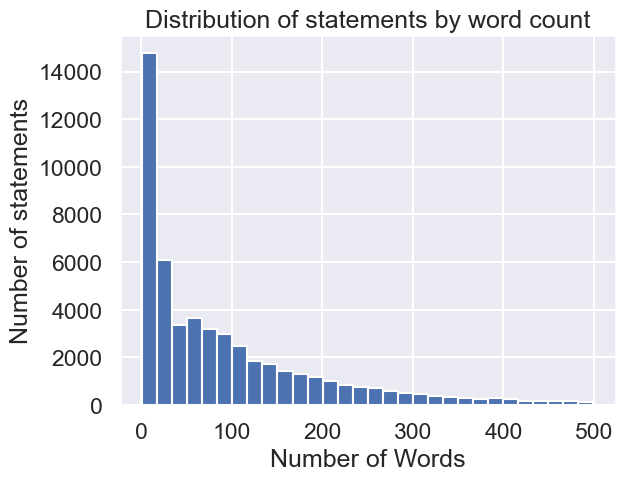

In [26]:
plt.hist(sentiment_df_cleaned[sentiment_df_cleaned["word_count"]<500]["word_count"], bins = 30)
plt.title('Distribution of statements by word count')
plt.xlabel('Number of Words')
plt.ylabel('Number of statements')

plt.show()

### 3. Distribution of number of sentences in each statement

In [27]:
longer_than_30_sentences = sentiment_df_cleaned[sentiment_df_cleaned["sentence_count"]>30].shape[0]
print(f'Percentage of long statements with more than 30 sentences is {100*longer_than_30_sentences/sentiment_df_cleaned.shape[0]} %')

Percentage of long statements with more than 30 sentences is 2.1774786493976586 %


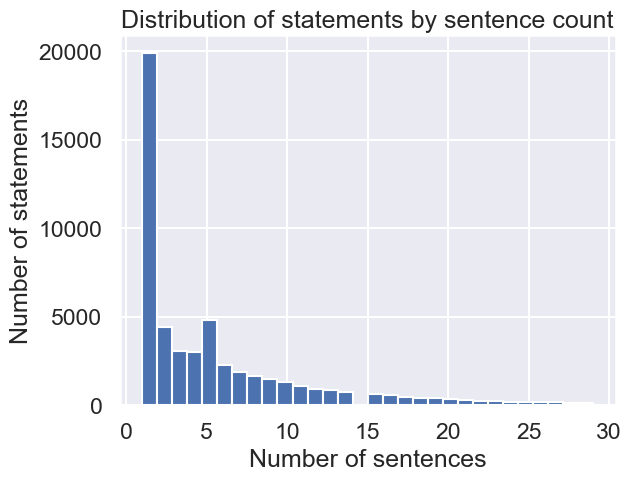

In [28]:
plt.hist(sentiment_df_cleaned[sentiment_df_cleaned["sentence_count"]<30]["sentence_count"], bins = 30)
plt.title('Distribution of statements by sentence count')
plt.xlabel('Number of sentences')
plt.ylabel('Number of statements')

plt.show()

### 4. Distribution of average number of characters per word in each statement

In [29]:
longer_than_10_characters_per_word = sentiment_df_cleaned[sentiment_df_cleaned["avg_character_per_word"]>10].shape[0]
print(f'Percentage of statements with avearge characters per word more than 10 is {100*longer_than_10_characters_per_word/sentiment_df_cleaned.shape[0]} %')

Percentage of statements with avearge characters per word more than 10 is 0.4807420394774051 %


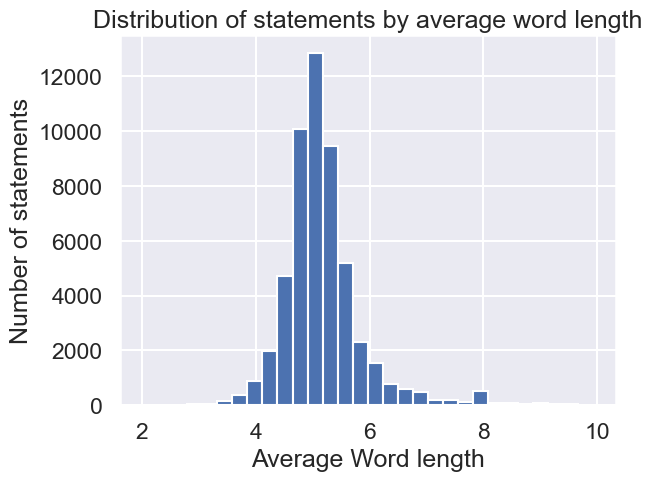

In [30]:
plt.hist(sentiment_df_cleaned[sentiment_df_cleaned["avg_character_per_word"]<10]["avg_character_per_word"], bins = 30)
plt.title('Distribution of statements by average word length')
plt.xlabel('Average Word length')
plt.ylabel('Number of statements')

plt.show()

### 5. Distribution of average number of characters per sentence in each statement

In [31]:
longer_than_500_characters_per_sentence = sentiment_df_cleaned[sentiment_df_cleaned["avg_character_per_sentence"]>500].shape[0]
print(f'Percentage of statements with avearge characters per sentence more than 500 is {100*longer_than_500_characters_per_sentence/sentiment_df_cleaned.shape[0]} %')

Percentage of statements with avearge characters per sentence more than 500 is 3.883641573817469 %


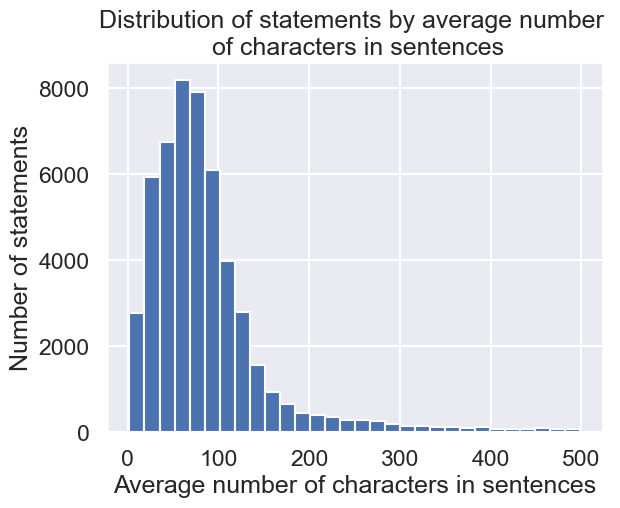

In [40]:
plt.hist(sentiment_df_cleaned[sentiment_df_cleaned["avg_character_per_sentence"]<500]["avg_character_per_sentence"], bins = 30)
plt.title('Distribution of statements by average number \n of characters in sentences')
plt.xlabel('Average number of characters in sentences')
plt.ylabel('Number of statements')

plt.show()

### 6. Distribution of average number of words per sentences in each statement

In [33]:
longer_than_100_words_per_sentence = sentiment_df_cleaned[sentiment_df_cleaned["avg_word_per_sentence"]>100].shape[0]
print(f'Percentage of statements with avearge words per sentence more than 100 is {100*longer_than_100_words_per_sentence/sentiment_df_cleaned.shape[0]} %')

Percentage of statements with avearge words per sentence more than 100 is 3.964707878513659 %


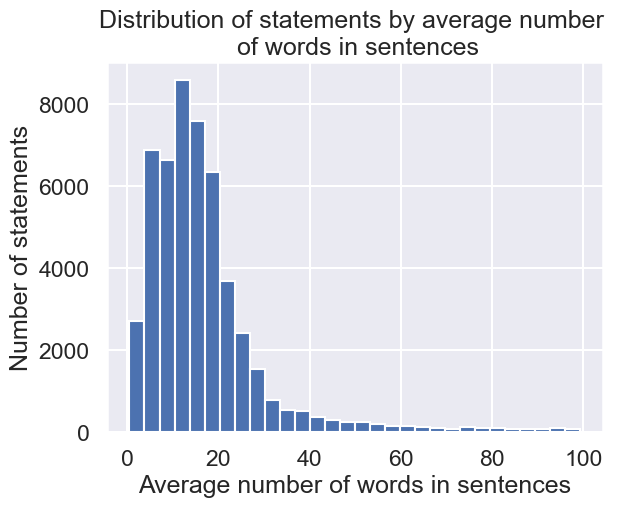

In [41]:
plt.hist(sentiment_df_cleaned[sentiment_df_cleaned["avg_word_per_sentence"]<100]["avg_word_per_sentence"], bins = 30)
plt.title('Distribution of statements by average number \n of words in sentences')
plt.xlabel('Average number of words in sentences')
plt.ylabel('Number of statements')

plt.show()

### 7. Target variable with respect to three newly generated features in 3D Scatterplot 

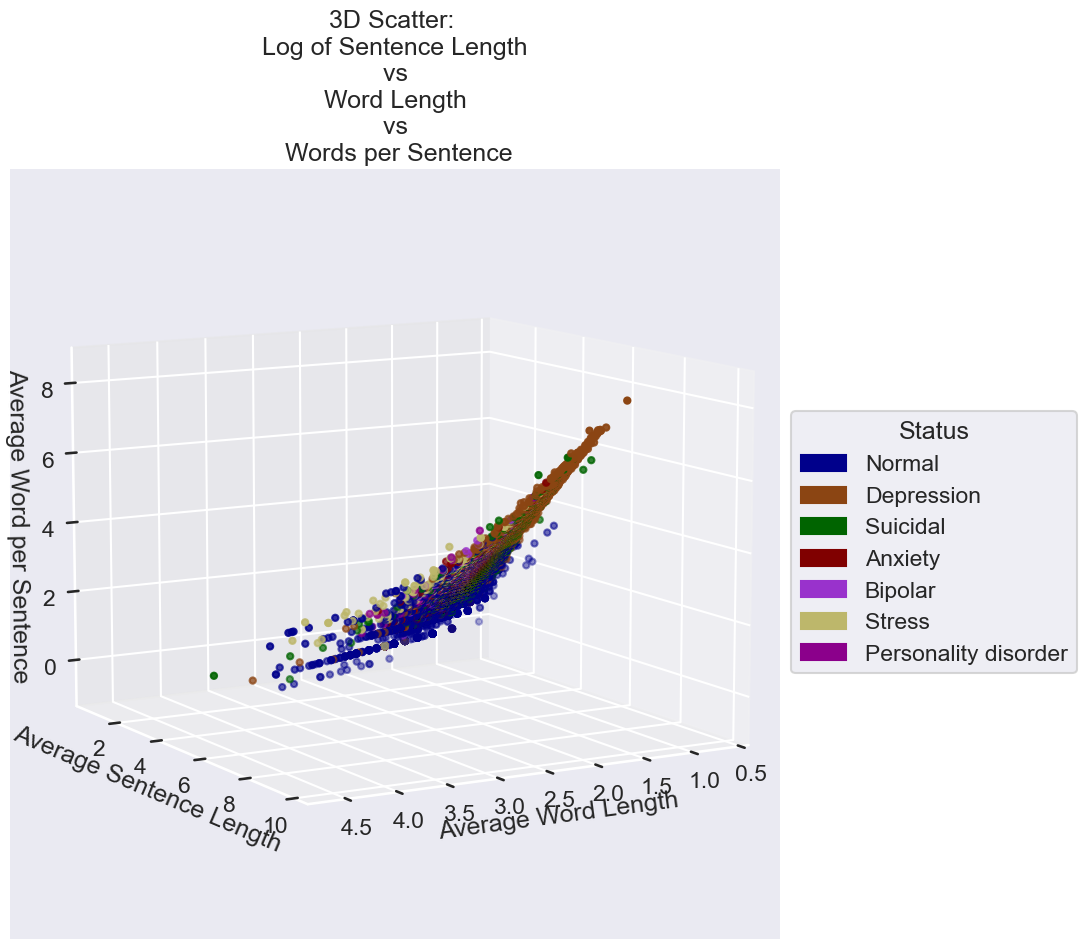

In [54]:
from mpl_toolkits.mplot3d import Axes3D


# Filter and transform the data
filtered_data = sentiment_df_cleaned[sentiment_df_cleaned["avg_character_per_word"] < 100]
x = np.log(filtered_data["avg_character_per_word"])
y = np.log(filtered_data["avg_character_per_sentence"])
z = np.log(filtered_data["avg_word_per_sentence"])
# Manually map the status to colors
color_mapping = {
    "Normal": "#00008B",
    "Depression": "#8B4513",
    "Suicidal": "#006400",
    "Anxiety": "#800000",
    "Bipolar": "#9932CC",
    "Stress": "#BDB76B",
    "Personality disorder": "#8B008B"
}

# Apply the mapping to get colors
colors = filtered_data["status"].map(color_mapping)

# Create a 3D plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
scatter = ax.scatter(x, y, z, c=colors, marker='o')

# Add labels
ax.set_xlabel('Average Word Length')
ax.set_ylabel('Average Sentence Length')
ax.set_zlabel('Average Word per Sentence')

# Set the view angle for rotation
ax.view_init(elev=10, azim=60)  # Adjust these values for the desired rotation

# Create a custom legend
import matplotlib.patches as mpatches

# Create handles for the legend
handles = [mpatches.Patch(color=color_mapping[label], label=label) for label in color_mapping.keys()]

# Add the legend to the plot, positioning it outside the graph
ax.legend(handles=handles, title='Status', loc='upper left', bbox_to_anchor=(1, 0.7))
# Add title
plt.title('3D Scatter: \n Log of Sentence Length \n vs \n Word Length \n vs \n Words per Sentence')

# Show plot
plt.show()

Above figure clearly shows newly generated features has high importance in deciding the target varible. The data looks like a pyramid with base more corresponding to "**Normal**" status while "**Depression**" lies at the top of the pyramid.

### 8. Word Clouds to visualize the relative importance of words in each status category

Creating word clouds is a great way to visualize the relative importance or frequency of words in different categories, like various status categories in a dataset. Word clouds display words in sizes that correspond to their frequency or importance, allowing you to quickly identify prominent words.

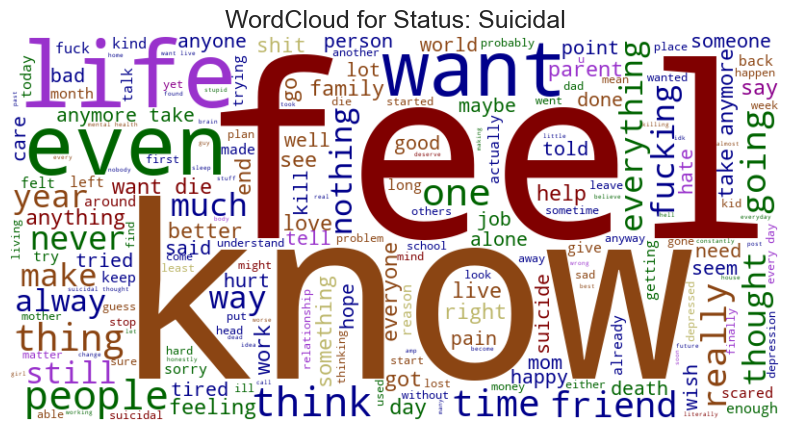

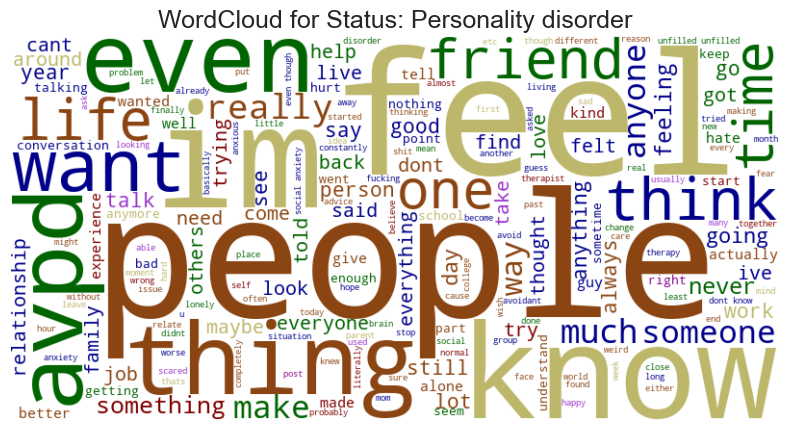

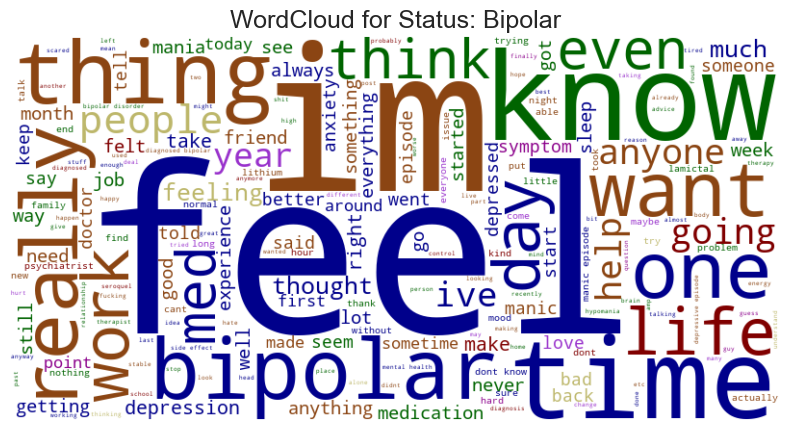

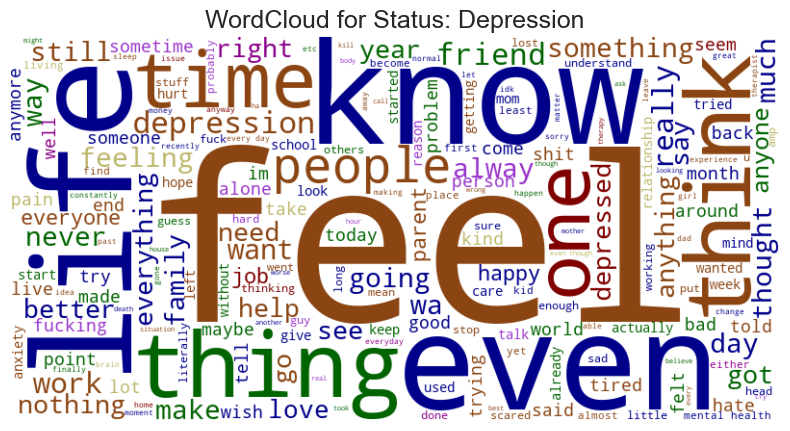

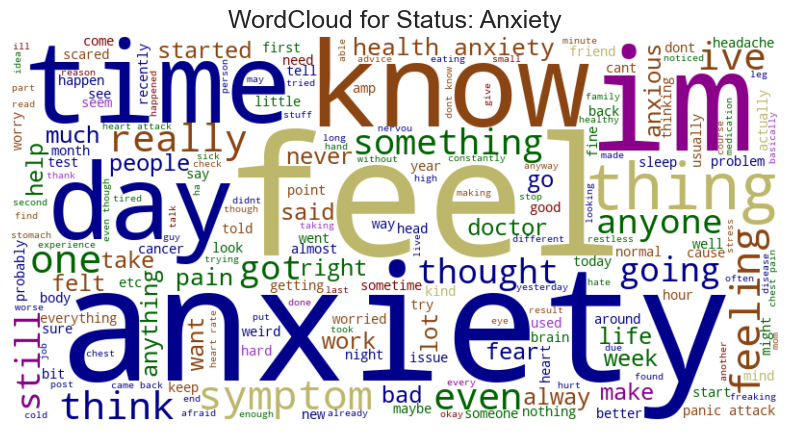

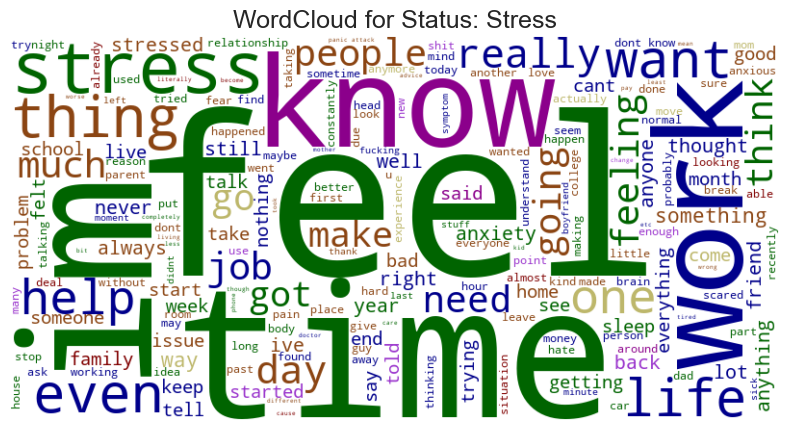

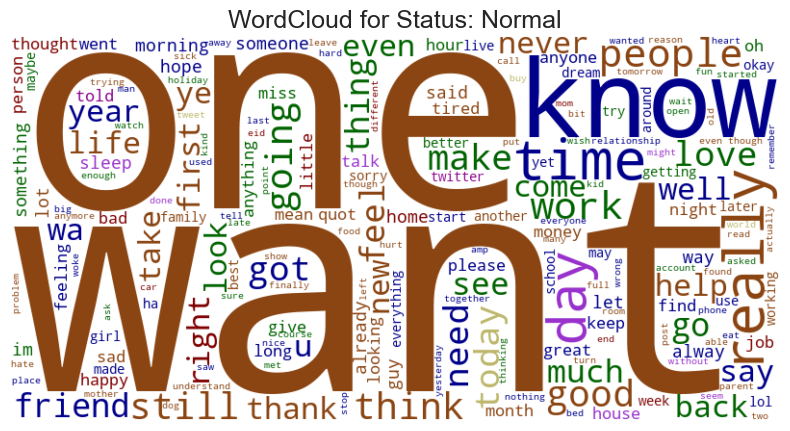

In [36]:
statuses = sentiment_df_cleaned["status"].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Return the color based on the current status (from outer loop)
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    current_status = status  # Set the current status to use in the color function
    
    # Filter the tokens data for the current status and join them into a single string
    tokens_data = ' '.join(sentiment_df_cleaned[sentiment_df_cleaned['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()


It seems many words such as "**Feel**", "**Want**" etc are used with overlap across different statuses. It has to be taken care of while building a model.

TF-IDF (Term Frequency-Inverse Document Frequency) is an excellent way to handle the overlap of words across different categories (statuses) in Natural Language Processing (NLP). TF-IDF helps distinguish words that are common across all categories from words that are more important and unique to specific categories, which can significantly improve the performance of classification models.

## Saving the data for later use

In [37]:
sentiment_df_cleaned.to_csv("../data/Interim/sentiment_df_cleaned.csv")